## Get Started with AutoAttack

__Description__:

This notebook quickly demonstrates the use of AutoAttack in code as part of Test & Evaluation of small benchmark datasets (MNIST and CIFAR-10). 
Key features:
- Attacks are demonstrated using parallel and non-parallel mode.
- Extracting attack metadata to determine the best performing attacks.
- Calculating clean and robust accuracy
- Calculating perturbation

__Intended Audience__: Advanced T&E users

## Contents
1. Imports
2. Load CIFAR-10 model and data
3. Define attacks
4. Execute attacks
5. Test attack effectiveness
6. Calculate clean and robust accuracy
7. Visualize the images
8. Determine optimal attack
9. Load MNIST model and data
10. Define and execute attacks
11. Calculate clean and robust accuracy
12. Visualize the images
13. Hint: default AutoAttack

## 1. Imports

In [1]:
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack
from art.attacks.evasion.auto_attack import AutoAttack
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from art.utils import load_dataset

%matplotlib inline

## 2. Load CIFAR-10 model and data
- In this repository we have stored a simple classification model which can be used with CIFAR-10
- ART also contains a utility method for easily loading CIFAR-10 images as ```numpy arrays``` 
- Once the model is loaded, we can wrap it in ```JaticPyTorchClassifier``` so the model is compatible with  __maite__

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')
i = 10
x_train = x_train[:i, :].transpose(0, 3, 1, 2).astype('float32')
x_test = x_test[:i, :].transpose(0, 3, 1, 2).astype('float32')
y_train = y_train[:i, :].astype('float32')
y_test = y_test[:i, :].astype('float32')

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '../'

class Model(torch.nn.Module):
    """
    Create model for pytorch.
    Here the model does not use maxpooling. Needed for certification tests.
    """

    def __init__(self):
        super(Model, self).__init__()

        self.conv = torch.nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
        )

        self.fullyconnected = torch.nn.Linear(in_features=1600, out_features=10)

        self.relu = torch.nn.ReLU()

        w_conv2d = np.load(
            os.path.join(
                os.path.dirname(path),
                "utils/resources/models",
                "W_CONV2D_NO_MPOOL_CIFAR10.npy",
            )
        )
        b_conv2d = np.load(
            os.path.join(
                os.path.dirname(path),
                "utils/resources/models",
                "B_CONV2D_NO_MPOOL_CIFAR10.npy",
            )
        )
        w_dense = np.load(
            os.path.join(
                os.path.dirname(path),
                "utils/resources/models",
                "W_DENSE_NO_MPOOL_CIFAR10.npy",
            )
        )
        b_dense = np.load(
            os.path.join(
                os.path.dirname(path),
                "utils/resources/models",
                "B_DENSE_NO_MPOOL_CIFAR10.npy",
            )
        )

        self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
        self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
        self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
        self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

    def forward(self, x):
        """
        Forward function to evaluate the model
        :param x: Input to the model
        :return: Prediction of the model
        """
        x = self.conv(x)
        x = self.relu(x)
        x = x.reshape(-1, 1600)
        x = self.fullyconnected(x)
        # x = torch.nn.functional.softmax(x, dim=1) # removed to return logits
        return x

# Define the network
model = Model()

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get classifier
ptc = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32), nb_classes=(10), clip_values=(0, 1), channels_first=False,
)

## 3. Define attacks
Create a number of differently initialized attacks to carry out the T&E.
- vary the max_iter values, all others fixed
- vary the eps_step values, all others fixed
- other parameters can/should be further explored, as well as applying different attacks

Once attacks are defined:
- add the attacks to ```AutoAttack``` which will manage the attack execution
- wrap the attacks with ```JaticAttack``` which supports  __maite__
- note, for comparison, we also define AutoAttack using standard ART core

Set Parallel Pool Size to enable Parallel AutoAttack:
- Setting a [multiprocess pool size value](https://docs.python.org/3.11/library/multiprocessing.html#module-multiprocessing.pool) allows AutoAttack to execute across a specified number of worker processes.
- By default, the AutoAttack `parallel_pool_size` value is 0, which disables the usage of parallel AutoAttack.

In [3]:
# You can modify this value to either raise or lower the number of multiprocess workers spawned by Parallel AutoAttack
parallel_pool_size = 2

print(f"Count of total (logical) CPUs available: os.cpu_count() = {os.cpu_count()}")
print(f"Pool size to use during parallel AutoAttack: parallel_pool_size = {parallel_pool_size}")

Count of total (logical) CPUs available: os.cpu_count() = 16
Pool size to use during parallel AutoAttack: parallel_pool_size = 2


In [5]:
n = 20
attacks = []

# create multiple values for max_iter
max_iter = [i+1 for i in list(range(n))]
print('max_iter values:', max_iter)

# create multiple values for eps
eps_steps = [round(float(i/100+0.001), 3) for i in list(range(n))]
print('eps_step values:', eps_steps)

for i, eps_step in enumerate(eps_steps):
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=ptc,
            norm=np.inf,
            eps=0.1,
            eps_step=eps_step,
            max_iter=10,
            targeted=False,
            batch_size=32,
            verbose=False
        )
    )
    attacks.append(
        ProjectedGradientDescentPyTorch(
            estimator=ptc,
            norm=np.inf,
            eps=0.1,
            max_iter=max_iter[i],
            targeted=False,
            batch_size=32,
            verbose=False
        )
    )
    
print('Number of attacks:', len(attacks))

jatic_attack_parallel = JaticAttack(AutoAttack(estimator=ptc, attacks=attacks, targeted=True, parallel_pool_size=parallel_pool_size), norm=2)
jatic_attack_notparallel = JaticAttack(AutoAttack(estimator=ptc, attacks=attacks, targeted=True), norm=2)
core_attack = AutoAttack(estimator=ptc, attacks=attacks, targeted=True)

max_iter values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
eps_step values: [0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081, 0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171, 0.181, 0.191]
Number of attacks: 40


## 4. Execute attacks
Here we are executing all the attacks:
- using ART core
- using HEART in non-parallel mode
- using HEART in parallel mode

In [6]:
from typing import Tuple, Dict, Any
from maite.protocols.image_classification import Dataset as ic_dataset

class ImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self)->int:
        return len(self.images)
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images[ind]
        label = self.labels[ind]
        return image, label, {}
    
data = ImageDataset(x_train, y_train)

assert isinstance(data, ic_dataset)

In [8]:
# Run core ART attack
core_adv = core_attack.generate(x=x_train, y=y_train)

# Run HEART attack in non-parallel mode
nonparallel_adv, y_nonparallel, metadata_nonparallel = jatic_attack_notparallel(data=data)

# Disable the Pytorch optimizer for parallel AutoAttack as it is not needed and may cause serialization issues
jatic_attack_parallel._attack.estimator_orig._optimizer = None

# Run HEART attack in parallel mode
parallel_adv, y_parallel, metadata_parallel = jatic_attack_parallel(data=data)

## 5. Test attack effectiveness
- Is the attack robust? If the attack is robust, predictions for each image will be incorrect and therefore the attack is fully robust.

In [9]:
predictions_core_adv = np.sum(np.argmax(np.stack(ptc(core_adv)), axis=1) == np.argmax(y_train, axis=1)) == 0
predictions_jatic_parallel = np.sum(np.argmax(np.stack(ptc(parallel_adv)), axis=1) == np.argmax(y_train, axis=1)) == 0
predictions_jatic_notparallel = np.sum(np.argmax(np.stack(ptc(nonparallel_adv)), axis=1) == np.argmax(y_train, axis=1)) == 0


print(f'Is core ART attack fully robust: {predictions_core_adv}')
print(f'Is HEART non-parallel attack fully robust: {predictions_jatic_notparallel}')
print(f'Is HEART parallel attack fully robust: {predictions_jatic_parallel}')

Is core ART attack fully robust: True
Is HEART non-parallel attack fully robust: True
Is HEART parallel attack fully robust: True


## 6. Calculate clean and robust accuracy

- clean accuracy: this is the accuracy of the classification model on the original, benign, images
- robust accuracy: this is the accuracy of the classification  model on the adversarial images
- perturbation: this is the average perturbation added to all images which successfully fooled the classification model

In [10]:
from heart_library.metrics import AccuracyPerturbationMetric

benign_pred_batch = ptc(x_train)
groundtruth_target_batch = np.argmax(y_parallel, axis=1)
adv_pred_batch = ptc(parallel_adv)

metric = AccuracyPerturbationMetric(np.stack(benign_pred_batch), metadata_parallel)
metric.update(np.stack(adv_pred_batch), groundtruth_target_batch)
print(metric.compute())

{'clean_accuracy': 0.5, 'robust_accuracy': 0.0, 'mean_delta': 1.3108634}


## 7. Visualize the images

- The first column images is the original image. The title shows the ground truth label and the classifier prediction on the original image. Note that as we are passing ground truth labels to the __generate__ method, attacks won't add perturbations to images that are already misclassified. Perturbations are added to images in which the classifier made correct predictions.

- The second column images are adversarial images generated by ART core AutoAttack. L2 distance between the original and adversarial image are shown. 

- The third column images are adversarial images generated by ART JATIC AutoAttack in non-parallel mode - these should be identical to ART core (this is a sanity check to ensure changes have not changed core functionality).

- The fourth column images are adversarial images generated by ART JATIC AutoAttack in parallel mode. Note how parallel model achieves lower L2 distance between the original and adversarial image - as all jobs are run in parallel mode, more attacks can be evaluated and successful attacks with lower perturbations added can be selected.

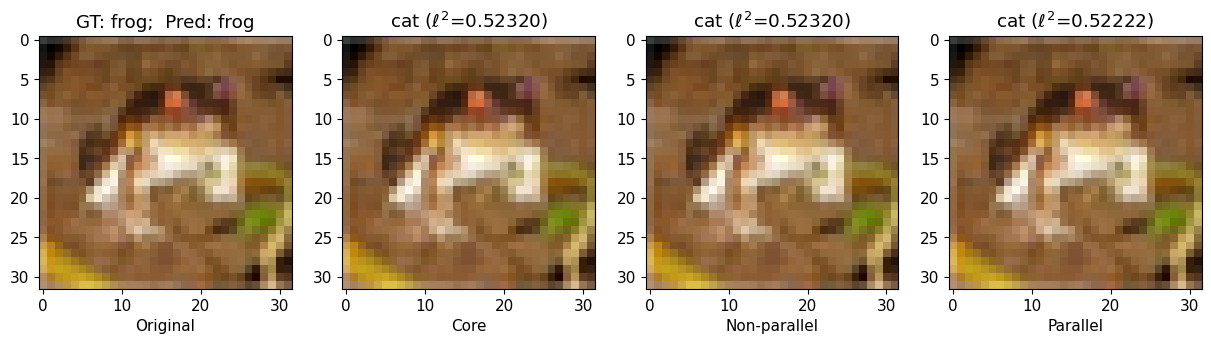

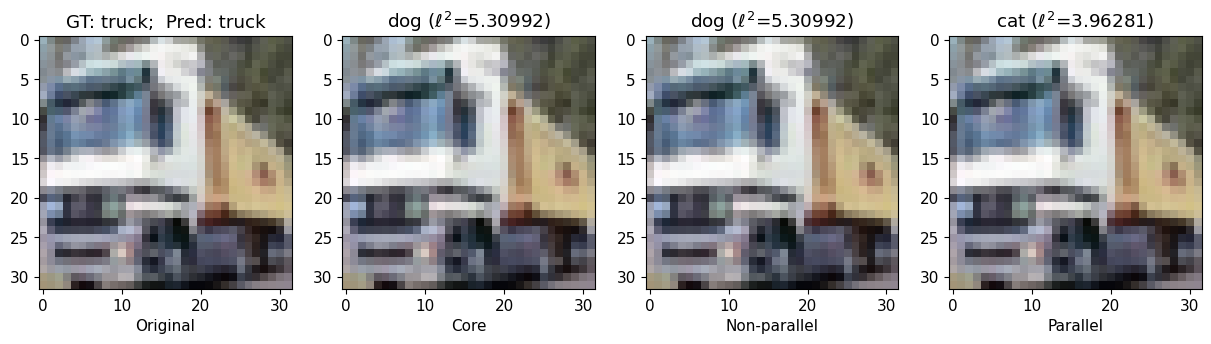

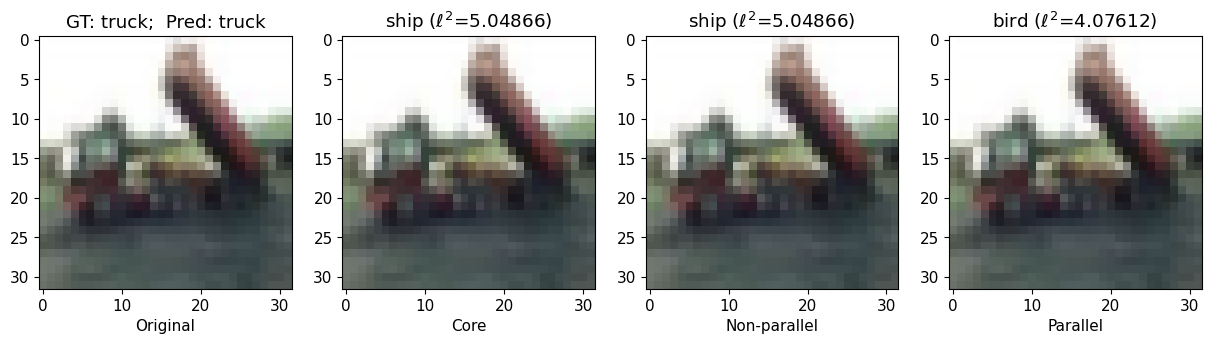

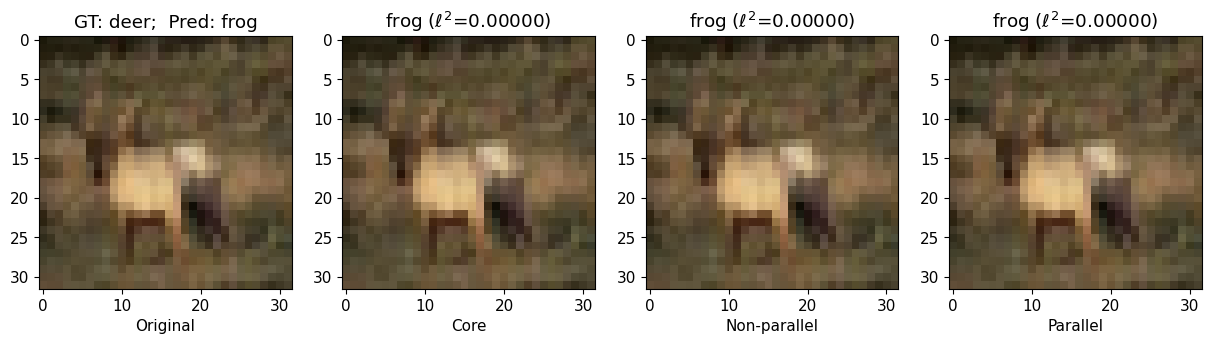

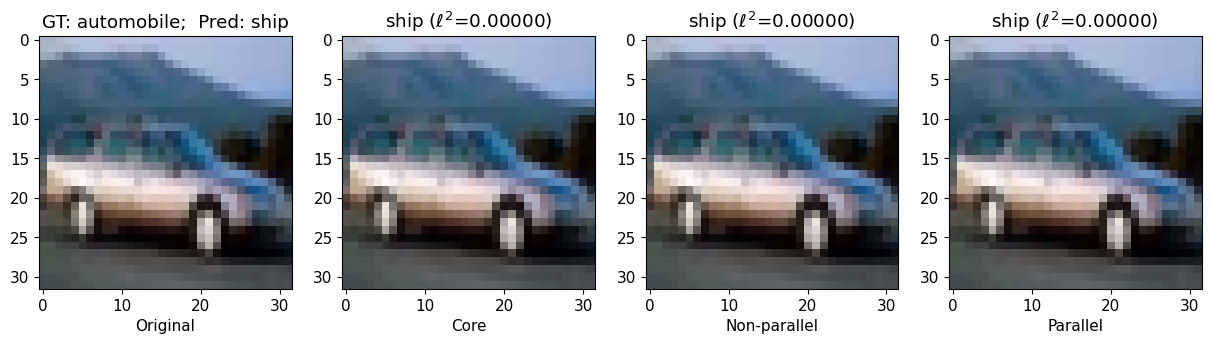

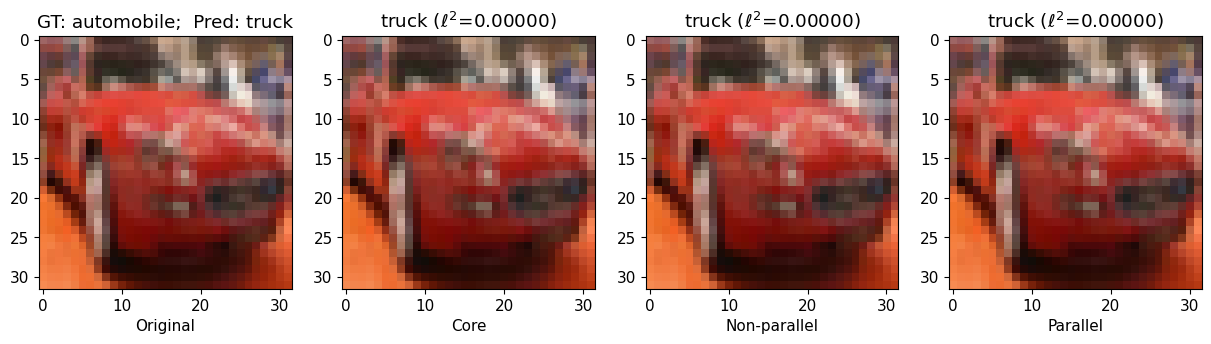

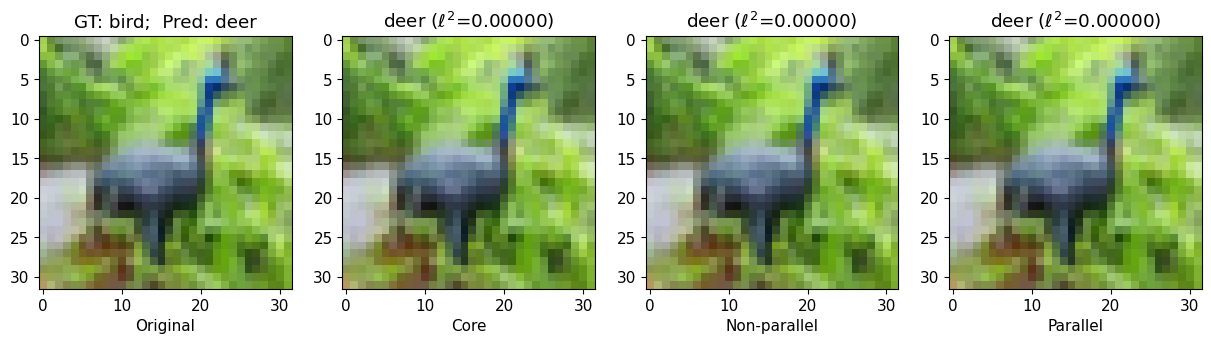

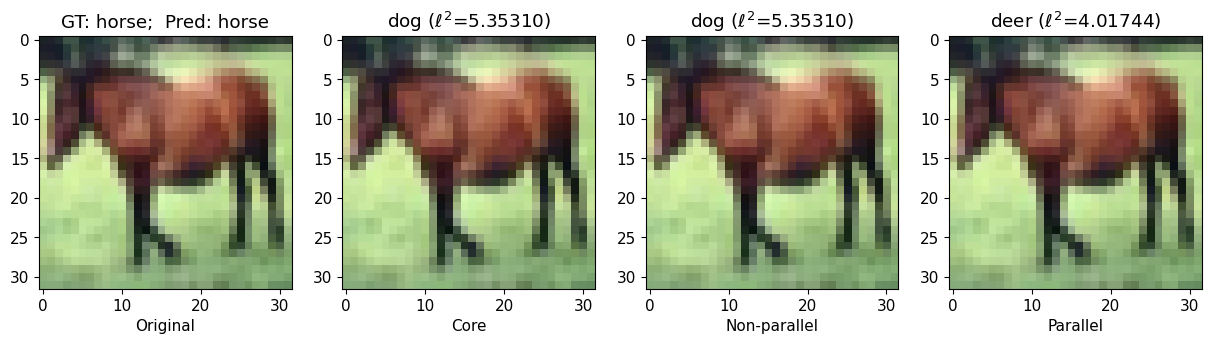

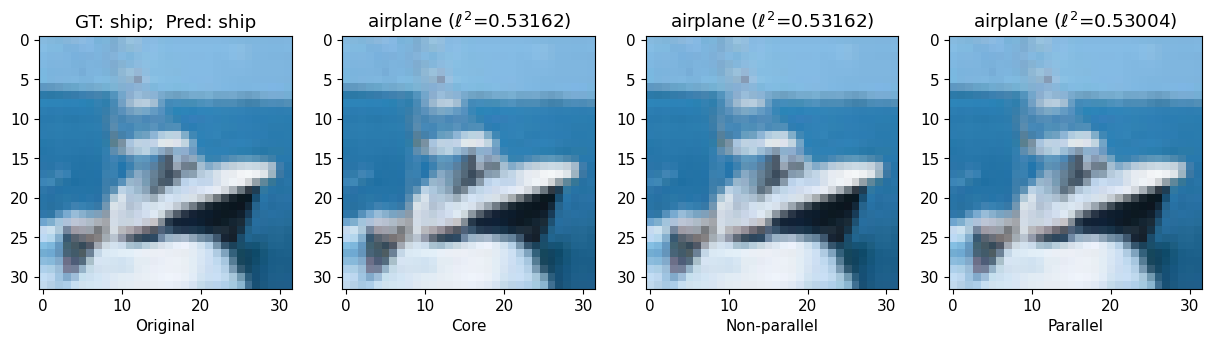

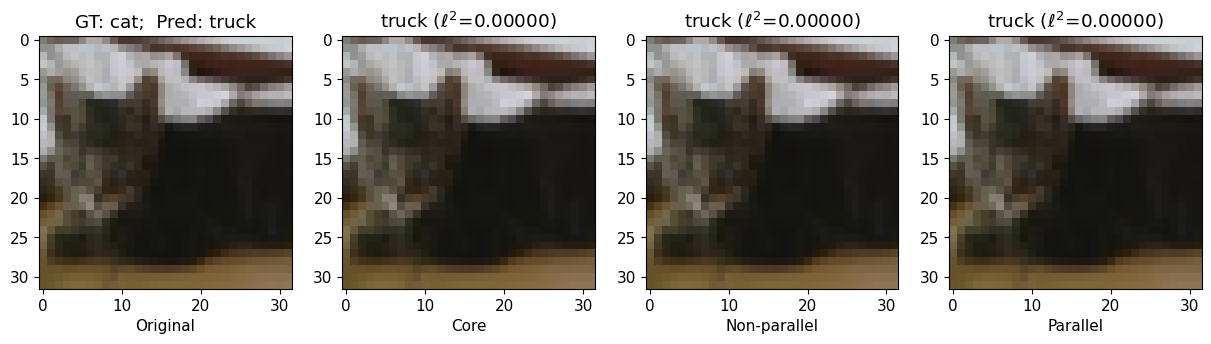

In [11]:
for i in range(len(x_train)):
    f, ax = plt.subplots(1,4, constrained_layout = False)

    core_perturbation = np.linalg.norm(x_train[i] - core_adv[[i]])
    nonparallel_perturbation = np.linalg.norm(x_train[i] - nonparallel_adv[i])
    parallel_perturbation = np.linalg.norm(x_train[i] - parallel_adv[i])
    
    pred_core_benign = ptc.predict(x_train[i])
    pred_core_adv = ptc.predict(core_adv[i])
    pred_non_parallel_adv = np.stack(ptc(nonparallel_adv[i]))
    pred_parallel_adv = np.stack(ptc(parallel_adv[i]))

    ax[0].set_title(f'GT: {labels[np.argmax(y_train[i])]};  Pred: {labels[np.argmax(pred_core_benign)]}')
    ax[0].imshow(x_train[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')
    
    ax[1].set_title(f'{labels[np.argmax(pred_core_adv)]} ($\\ell ^{2}$={core_perturbation:.5f})')
    ax[1].imshow(x_train[i].transpose(1,2,0))
    ax[1].set_xlabel('Core')

    ax[2].set_title(f'{labels[np.argmax(pred_non_parallel_adv)]} ($\\ell ^{2}$={nonparallel_perturbation:.5f})')
    ax[2].imshow(x_train[i].transpose(1,2,0))
    ax[2].set_xlabel('Non-parallel')

    ax[3].set_title(f'{labels[np.argmax(pred_parallel_adv)]} ($\\ell ^{2}$={parallel_perturbation:.5f})')
    ax[3].imshow(x_train[i].transpose(1,2,0))
    ax[3].set_xlabel('Parallel')
    f.set_figwidth(15)
    plt.show()

## 8. Determine optimal attack

- What were the best attacks for each image?
- ```AutoAttack``` provides a useful utility for showing which attacks were most effective per image and the parameters to achieve the best attack
- if an image has ```n/a``` in place of an attack, it means the classifier failed to correctly predict the class for the image and so the original image was deemed already 'adversarial'

In [12]:
print(jatic_attack_parallel._attack)

AutoAttack(targeted=True, parallel_pool_size=2, num_attacks=400)
BestAttacks:
image 1: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.001, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=10, random_eps=False, verbose=False, )
image 2: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.1, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=2, random_eps=False, verbose=False, )
image 3: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.011, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=10, random_eps=False, verbose=False, )
image 4: n/a
image 5: n/a
image 6: n/a
image 7: n/a
image 8: ProjectedGradientDescentPyTorch(norm=inf, eps=0.1, eps_step=0.1, targeted=True, num_random_init=0, batch_size=32, minimal=False, summary_writer=None, decay=None, max_iter=2, random_eps=False, verbose=F

## 9. Load MNIST model and data

- The following is a demonstration, similar to above, but using the MNIST dataset and an associated model.
- Useful Note: in ```AutoAttack```, attacks which do not support targeted attacks are not run in targeted mode and warning is provided.

In [13]:
from art.attacks.evasion.auto_attack import AutoAttack, AutoProjectedGradientDescent
from art.estimators.classification.pytorch import PyTorchClassifier
import numpy as np
import os
from tests.utils import load_dataset
import torch
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent_pytorch import ProjectedGradientDescentPyTorch


def get_image_classifier_pt(from_logits=False, load_init=True, use_maxpool=True):
    """
    Standard PyTorch classifier for unit testing.

    :param from_logits: Flag if model should predict logits (True) or probabilities (False).
    :type from_logits: `bool`
    :param load_init: Load the initial weights if True.
    :type load_init: `bool`
    :param use_maxpool: If to use a classifier with maxpool or not
    :type use_maxpool: `bool`
    :return: PyTorchClassifier
    """
    import torch

    path = '../'

    if use_maxpool:

        class Model(torch.nn.Module):
            """
            Create model for pytorch.

            The weights and biases are identical to the TensorFlow model in get_classifier_tf().
            """

            def __init__(self):
                super(Model, self).__init__()

                self.conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7)
                self.relu = torch.nn.ReLU()
                self.pool = torch.nn.MaxPool2d(4, 4)
                self.fullyconnected = torch.nn.Linear(25, 10)

                if load_init:
                    w_conv2d = np.load(
                        os.path.join(
                            os.path.dirname(path), "utils/resources/models", "W_CONV2D_MNIST.npy"
                        )
                    )
                    b_conv2d = np.load(
                        os.path.join(
                            os.path.dirname(path), "utils/resources/models", "B_CONV2D_MNIST.npy"
                        )
                    )
                    w_dense = np.load(
                        os.path.join(
                            os.path.dirname(path), "utils/resources/models", "W_DENSE_MNIST.npy"
                        )
                    )
                    b_dense = np.load(
                        os.path.join(
                            os.path.dirname(path), "utils/resources/models", "B_DENSE_MNIST.npy"
                        )
                    )

                    w_conv2d_pt = w_conv2d.reshape((1, 1, 7, 7))

                    self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d_pt))
                    self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
                    self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(np.transpose(w_dense)))
                    self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

            def forward(self, x):
                """
                Forward function to evaluate the model
                :param x: Input to the model
                :return: Prediction of the model
                """
                x = self.conv(x)
                x = self.relu(x)
                x = self.pool(x)
                x = x.reshape(-1, 25)
                x = self.fullyconnected(x)
                if not from_logits:
                    x = torch.nn.functional.softmax(x, dim=1)
                return x

    else:

        class Model(torch.nn.Module):
            """
            Create model for pytorch.
            Here the model does not use maxpooling. Needed for certification tests.
            """

            def __init__(self):
                super(Model, self).__init__()

                self.conv = torch.nn.Conv2d(
                    in_channels=1, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
                )

                self.fullyconnected = torch.nn.Linear(in_features=1296, out_features=10)

                self.relu = torch.nn.ReLU()

                if load_init:
                    w_conv2d = np.load(
                        os.path.join(
                            os.path.dirname(path),
                            "utils/resources/models",
                            "W_CONV2D_NO_MPOOL_MNIST.npy",
                        )
                    )
                    b_conv2d = np.load(
                        os.path.join(
                            os.path.dirname(path),
                            "utils/resources/models",
                            "B_CONV2D_NO_MPOOL_MNIST.npy",
                        )
                    )
                    w_dense = np.load(
                        os.path.join(
                            os.path.dirname(path),
                            "utils/resources/models",
                            "W_DENSE_NO_MPOOL_MNIST.npy",
                        )
                    )
                    b_dense = np.load(
                        os.path.join(
                            os.path.dirname(path),
                            "utils/resources/models",
                            "B_DENSE_NO_MPOOL_MNIST.npy",
                        )
                    )

                    self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
                    self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
                    self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
                    self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

            def forward(self, x):
                """
                Forward function to evaluate the model
                :param x: Input to the model
                :return: Prediction of the model
                """
                x = self.conv(x)
                x = self.relu(x)
                x = x.reshape(-1, 1296)
                x = self.fullyconnected(x)
                if not from_logits:
                    x = torch.nn.functional.softmax(x, dim=1)
                return x

    # Define the network
    model = Model()

    # Define a loss function and optimizer
    loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    labels = [0,1,2,3,4,5,6,7,8,9]
    # Get classifier
    ptc = JaticPyTorchClassifier(
        model=model, loss=loss_fn, optimizer=optimizer, input_shape=(1, 28, 28), nb_classes=10, clip_values=(0, 1)
    )

    return ptc

# Load MNIST data
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist), _, _ = load_dataset('mnist')

x_train_mnist = np.reshape(x_train_mnist, (x_train_mnist.shape[0],) + (1, 28, 28)).astype(np.float32)
x_test_mnist = np.reshape(x_test_mnist, (x_test_mnist.shape[0],) + (1, 28, 28)).astype(np.float32)

n_train = 10
n_test = 10
x_train_mnist = x_train_mnist[:n_train]
y_train_mnist = y_train_mnist[:n_train]
x_test_mnist = x_test_mnist[:n_test]
y_test_mnist = y_test_mnist[:n_test]

ptc = get_image_classifier_pt(from_logits=True)

## 10. Define and execute attacks

- Note: in this case we have defined attacks that don't support targeted mode
- Therefore ```AutoAttack``` recognizes that these attacks do not support targeted mode and skip
- These attacks are still executed in untargeted mode

In [14]:
from art.attacks.evasion.deepfool import DeepFool
from art.attacks.evasion import SquareAttack
from art.attacks.evasion.auto_attack import AutoAttack, AutoProjectedGradientDescent

norm = np.inf
eps = 0.3
eps_step = 0.1
batch_size = 32

attacks = list()
attacks.append(
    AutoProjectedGradientDescent(
        estimator=ptc,
        norm=norm,
        eps=eps,
        eps_step=eps_step,
        max_iter=100,
        targeted=True,
        nb_random_init=5,
        batch_size=batch_size,
        loss_type="cross_entropy",
        verbose=False,
    )
)
attacks.append(
    AutoProjectedGradientDescent(
        estimator=ptc,
        norm=norm,
        eps=eps,
        eps_step=eps_step,
        max_iter=100,
        targeted=False,
        nb_random_init=5,
        batch_size=batch_size,
        loss_type="difference_logits_ratio",
        verbose=False,
    )
)
attacks.append(DeepFool(classifier=ptc, max_iter=100, epsilon=1e-6, nb_grads=3, batch_size=batch_size, verbose=False,))
sa = SquareAttack(estimator=ptc, norm=norm, max_iter=5000, eps=eps, p_init=0.8, nb_restarts=5, verbose=False,)

attacks.append(sa)

attack = JaticAttack(AutoAttack(
    estimator=ptc,
    norm=norm,
    eps=eps,
    eps_step=eps_step,
    attacks=attacks,
    batch_size=batch_size,
    estimator_orig=None,
    targeted=True,
    parallel_pool_size=parallel_pool_size,
), norm=2)
data = {'images': x_train_mnist, 'labels': y_train_mnist, 'metadata': []}

# Disable the Pytorch optimizer for parallel AutoAttack as it is not needed and may cause serialization issues
attack._attack.estimator_orig._optimizer = None

x_train_mnist_adv, y, metadata = attack(data=data)

## 11. Calculate clean and robust accuracy


In [73]:
from heart_library.metrics import AccuracyPerturbationMetric

benign_pred_batch = ptc(x_train_mnist)
groundtruth_target_batch = np.argmax(y, axis=1)
adv_pred_batch = ptc(x_train_mnist_adv)

metric = AccuracyPerturbationMetric(benign_pred_batch, metadata)
metric.update(adv_pred_batch, groundtruth_target_batch)
print(metric.compute())

{'clean_accuracy': 0.2, 'robust_accuracy': 0.0, 'mean_delta': 0.24862233}


## 12. Visualize the images
- The image on the left is the original image - note the prediction and groundtruth labels
- The image on the right is the adversarial image
- Note that if the classifier made an incorrect prediction on the original image, then the adversarial image returned is identical to the original (perturbation = 0) as the attack determines that the original image is already 'adversarial' (causes a misclassification)
- If the prediction and groundtruth of the original image are identical, the attack adds perturbations until a misclassification occurs

AutoAttack(targeted=True, parallel_pool_size=2, num_attacks=22)
BestAttacks:
image 1: n/a
image 2: n/a
image 3: DeepFool(max_iter=100, epsilon=1e-06, nb_grads=3, batch_size=32, verbose=False, )
image 4: n/a
image 5: n/a
image 6: n/a
image 7: n/a
image 8: n/a
image 9: n/a
image 10: DeepFool(max_iter=100, epsilon=1e-06, nb_grads=3, batch_size=32, verbose=False, )


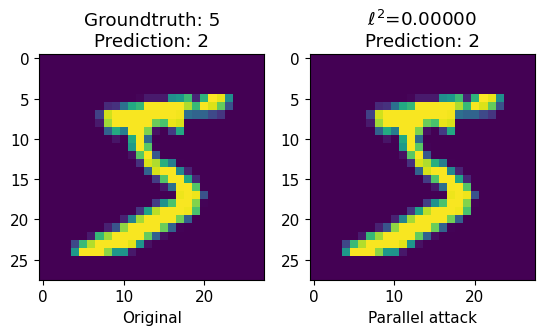

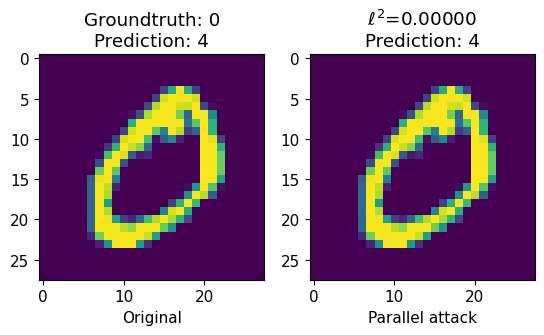

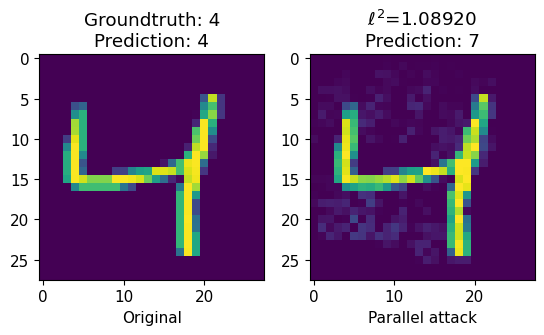

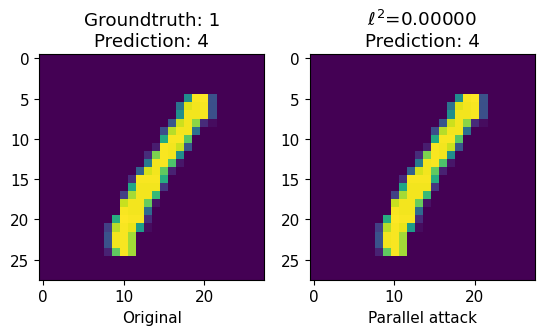

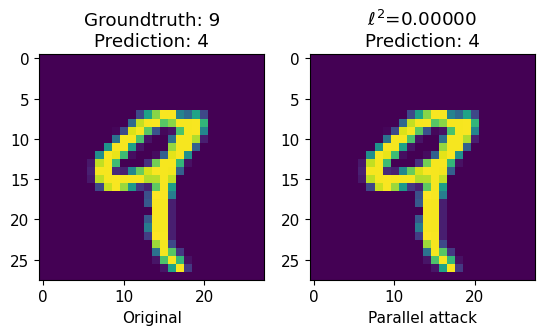

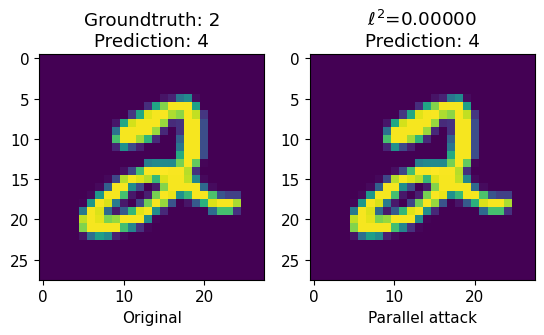

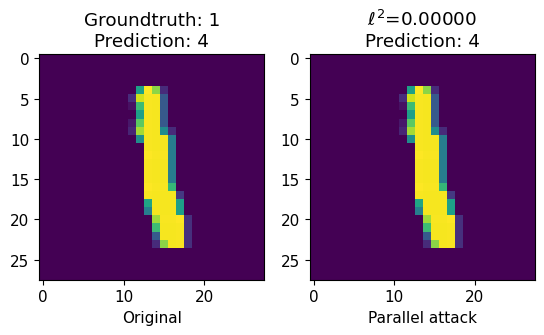

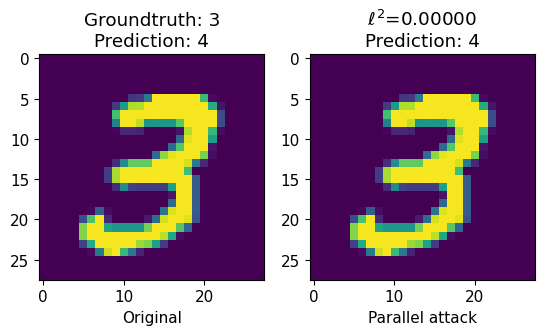

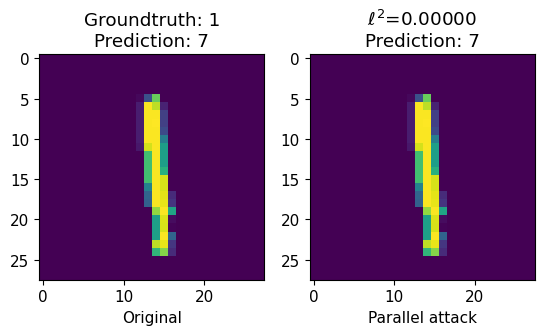

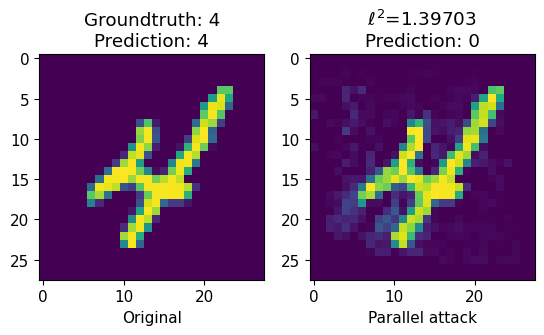

In [74]:
labels = [0,1,2,3,4,5,6,7,8,9]

for i in range(len(x_train_mnist)):
    f, ax = plt.subplots(1,2)

    perturbation = np.linalg.norm(x_train_mnist[i] - x_train_mnist_adv[i])

    ax[0].set_title(f'Groundtruth: {labels[np.argmax(y_train_mnist[[i]])]}\nPrediction: {labels[np.argmax(benign_pred_batch[i])]}')
    ax[0].imshow(x_train_mnist[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {labels[np.argmax(adv_pred_batch[i])]}')
    ax[1].imshow(x_train_mnist_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Parallel attack')
    
print(attack._attack)

## 13. Hint: default AutoAttack

In previous demonstrations, we as T&E users defined the attacks to be used by AutoAttack. If however, we do not have an intuition regarding which attack is most effective, we can start with the default AutoAttack parameters, which will give a good first impression about vulnerabilities.

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:  43%|████▎     | 43/100 [00:00<00:00, 424.19it/s]

AutoPGD - iteration:  42%|████▏     | 42/100 [00:00<00:00, 415.32it/s]

AutoPGD - iteration:  86%|████████▌ | 86/100 [00:00<00:00, 407.56it/s]

AutoPGD - iteration:  84%|████████▍ | 84/100 [00:00<00:00, 395.27it/s]

                                                                      
AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

                                                                      
AutoPGD - batch:   0%|          | 0/1 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:  31%|███       | 31/100 [00:00<00:00, 308.88it/s]

AutoPGD - iteration:  43%|████▎     | 43/100 [00:00<00:00, 429.91it/s]

AutoPGD - iterat

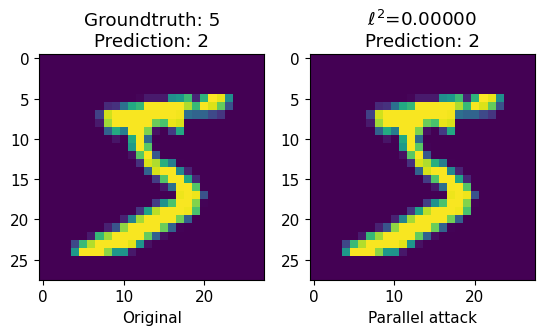

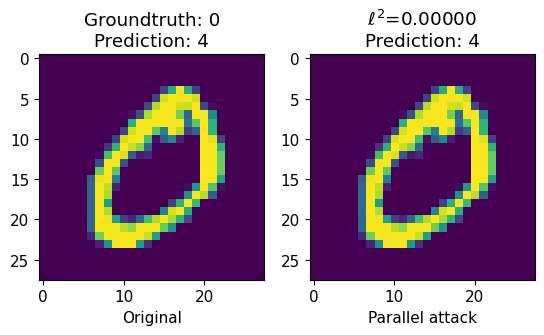

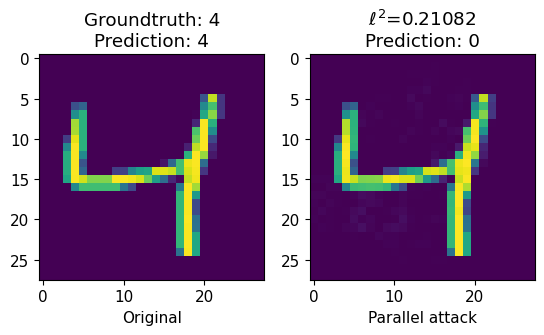

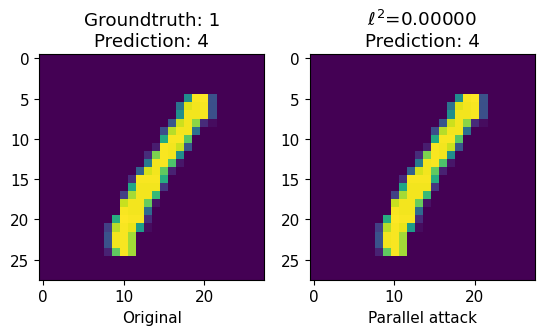

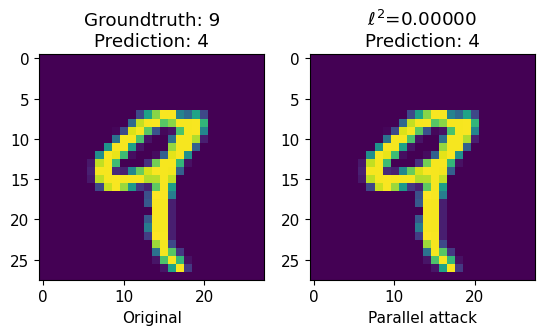

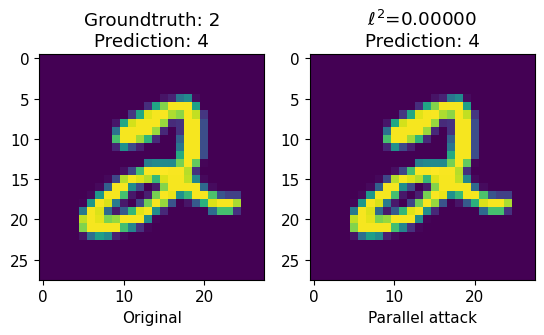

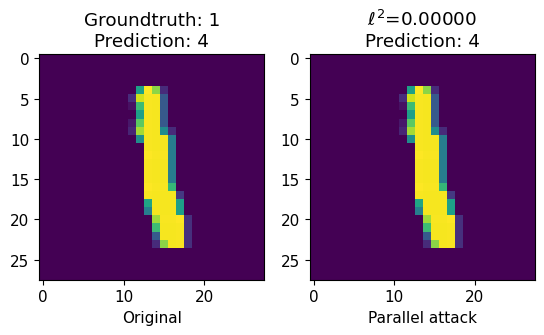

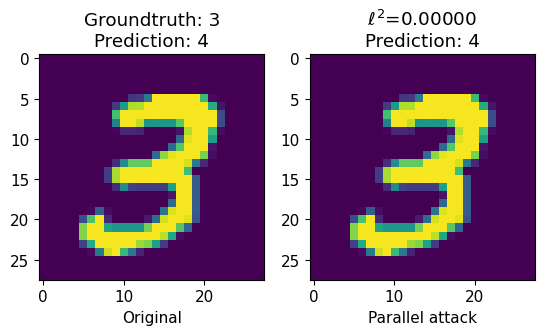

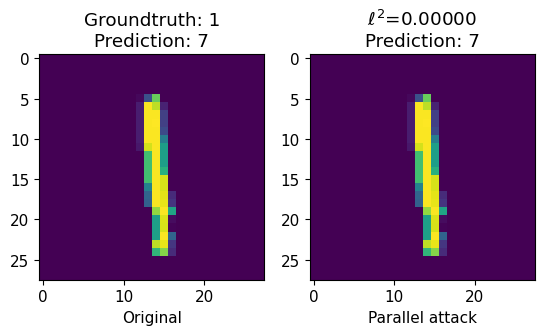

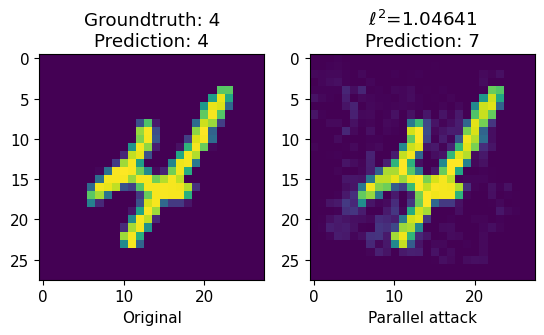

In [75]:
# First test with defined_attack_only=False
attack = JaticAttack(AutoAttack(
    estimator=ptc,
    targeted=True,
    parallel_pool_size=parallel_pool_size,
))
x_train_mnist_adv, _, _ = attack(data=data)

labels = [0,1,2,3,4,5,6,7,8,9]

for i in range(len(x_train_mnist)):
    f, ax = plt.subplots(1,2)

    perturbation = np.linalg.norm(x_train_mnist[i] - x_train_mnist_adv[i])

    ax[0].set_title(f'Groundtruth: {labels[np.argmax(y_train_mnist[[i]])]}\nPrediction: {labels[np.argmax(ptc.predict(x_train_mnist[i]))]}')
    ax[0].imshow(x_train_mnist[i].transpose(1,2,0))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {labels[np.argmax(ptc(x_train_mnist_adv[i]))]}')
    ax[1].imshow(x_train_mnist_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Parallel attack')

### What was the best attack identified for each image?

In [76]:
print(attack._attack)

AutoAttack(targeted=True, parallel_pool_size=2, num_attacks=22)
BestAttacks:
image 1: n/a
image 2: n/a
image 3: DeepFool(max_iter=100, epsilon=0.001, nb_grads=10, batch_size=32, verbose=True, )
image 4: n/a
image 5: n/a
image 6: n/a
image 7: n/a
image 8: n/a
image 9: n/a
image 10: DeepFool(max_iter=100, epsilon=0.001, nb_grads=10, batch_size=32, verbose=True, )
